# LIANA x Tensor-cell2cell Quickstart (R)

This tutorial provides an abbreviated version of Tutorials 01-06 in order to give a quick overview of the pipeline to go from a raw counts matrix to downstream cell-cell communication (CCC) analyses. By combining LIANA and Tensor-cell2cell, we get a general framework that can robustly incorporate many existing CCC inference tools, ultimately retriving consensus communication scores for any sample and analyzing all those samples together to identify context-dependent communication programs.  

## Initial Setups

### Enabling GPU use

First, if you are using a NVIDIA GPU with CUDA cores, set `use_gpu=TRUE` and enable PyTorch with the following code block. Otherwise, set `use_gpu=FALSE` or skip this part

In [51]:
use_gpu <- TRUE
library(reticulate, quietly = TRUE)
if (use_gpu){
    device <- 'cuda:0'
    tensorly <- reticulate::import('tensorly')
    tensorly$set_backend('pytorch')
}else{
    device <- NULL
}

### Libraries
Then, import all the packages we will use in this tutorial:

In [3]:
suppressMessages({
    library(dplyr, quietly = TRUE)
    library(tidyr, quietly = TRUE)
    library(purrr, quietly = TRUE)
    library(forcats, quietly = TRUE)
    library(textshape, quietly = TRUE)
    library(ggpubr, quietly = TRUE)
    
    library(scater, quietly = TRUE)
    library(scuttle, quietly = TRUE)
        
    library(ggplot2, quietly = TRUE)

    library(liana, quietly = TRUE)
    library(decoupleR, quietly = TRUE)
    c2c <- reticulate::import(module = "cell2cell")
})

### Directories

Afterwards, specify the data and output directories:

In [5]:
data_folder = '../../data/quickstart/'
output_folder = '../../data/quickstart/outputs'

for (folder_ in c(data_folder, output_folder)){
    if (!dir.exists(folder_)){
        dir.create(folder_)
    }
}

### Loading Data

We begin by loading the single-cell transcriptomics data. For this tutorial, we will use a lung [dataset](https://doi.org/10.1038/s41591-020-0901-9) of 63k immune and epithelial cells across three control, three moderate, and six severe COVID-19 patients21. We use a convenient function to download the data and store it in the AnnData format, on which the [scanpy](https://scanpy.readthedocs.io/en/stable/) package is built.

In [7]:
options(timeout=600)
covid_data <- readRDS(url('https://zenodo.org/record/7706962/files/BALF-COVID19-Liao_et_al-NatMed-2020_SCE.rds'))

## Preprocess Expression

Note, we do not include a batch correction step as Tensor-cell2cell can get robust decomposition results without this; however, we have extensive analysis and discuss regarding this topic in [Supplementary Tutorial 01](./S1_Batch_Correction.ipynb)

### Quality-Control Filtering

The loaded data has already been pre-processed to a degree and comes with cell annotations. Nevertheless, let’s highlight some of the key steps. To ensure that any noisy cells or features are removed, we filter any non-informative cells and genes:

In [9]:
# basic filters
covid_data <- scater::addPerCellQC(covid_data)
min.features <- 200
min.cells <- 3

sce_counts <- counts(covid_data)

if (min.features > 0) {
  nfeatures <- Matrix::colSums(x = sce_counts > 0)
  sce_counts <- sce_counts[, which(x = nfeatures >= min.features)]
}
# filter genes on the number of cells expressing
if (min.cells > 0) {
  num.cells <- Matrix::rowSums(x = sce_counts > 0)
  sce_counts <- sce_counts[which(x = num.cells >= min.cells), ]
}

covid_data<-covid_data[rownames(sce_counts), colnames(sce_counts)]

We additionally remove high mitochondrial content:

In [11]:
is.mito <- grep("MT-", rownames(covid_data))
per.cell <- scuttle::perCellQCMetrics(covid_data, subsets=list(Mito=is.mito))
colData(covid_data)[['subsets_Mito_percent']] <- per.cell$subsets_Mito_percent
covid_data <- covid_data[, colData(covid_data)$subsets_Mito_percent < 15] 

Which is followed by removing cells with high number of total UMI counts, potentially representing more than one single cell (doublets):

In [12]:
covid_data <- covid_data[, colData(covid_data)$detected < 5500] 

### Normalization

Normalized counts are usually obtained in two essential steps, the first being count depth scaling which ensures that the measured count depths are comparable across cells. This is then usually followed up with log1p transformation, which essentially stabilizes the variance of the counts and enables the use of linear metrics downstream:

In [13]:
scale.factor <- 1e4
lib.sizes <- colSums(counts(covid_data)) / scale.factor
assay(covid_data, 'logcounts') <- scuttle::normalizeCounts(covid_data, size.factors=lib.sizes, log=FALSE, center.size.factors=FALSE)
assay(covid_data, 'logcounts') <- log1p(assay(covid_data, 'logcounts'))

Let's see what our data looks like:

In [16]:
head(colData(covid_data))

DataFrame with 6 rows and 13 columns
                      orig.ident      sample  sample_new     disease
                     <character> <character> <character> <character>
AAACCCACAGCTACAT-1_1        C100        C100         HC3           N
AAACCCATCCACGGGT-1_1        C100        C100         HC3           N
AAACCCATCCCATTCG-1_1        C100        C100         HC3           N
AAACGAACAAACAGGC-1_1        C100        C100         HC3           N
AAACGAAGTCGCACAC-1_1        C100        C100         HC3           N
AAACGAAGTCTATGAC-1_1        C100        C100         HC3           N
                         hasnCoV   cluster   cell.type   condition    ident
                     <character> <integer> <character> <character> <factor>
AAACCCACAGCTACAT-1_1           N        27           B     Control     C100
AAACCCATCCACGGGT-1_1           N        23 Macrophages     Control     C100
AAACCCATCCCATTCG-1_1           N         6           T     Control     C100
AAACGAACAAACAGGC-1_1           

## Deciphering Cell-Cell Communication

we will use LIANA to infer the ligand-receptor interactions for each sample. LIANA is  highly modularized and it natively implements the formulations of a number of methods, including CellPhoneDBv2, Connectome, log2FC, NATMI, SingleCellSignalR, CellChat, a geometric mean, as well as a consensus in the form of a rank aggregate from any combination of methods

In [20]:
liana::show_methods()

[1] "connectome"      "logfc"           "natmi"           "sca"            
 [5] "cellphonedb"     "cytotalk"        "call_squidpy"    "call_cellchat"  
 [9] "call_connectome" "call_sca"        "call_italk"      "call_natmi"

LIANA classifies the scoring functions from the different methods into two categories: those that infer the “Magnitude” and “Specificity” of interactions. We define the “Magnitude” of an interaction as a measure of the strength of the interaction's expression, and the “Specificity” of an interaction is a measure of how specific an interaction is to a given pair of clusters. Generally, these categories are complementary, and the magnitude of the interaction is often a proxy of the specificity of the interaction. For example, a ligand-receptor interaction with a high magnitude score in a given pair of cell types is likely to also be specific, and vice versa. 


For clarity, here we map each output score (column names in the above dataframe) to the scoring method and scoring type:

| Method Name | Magnitude Score | Specificity Score |
| :- | -: | :-: |
| CellPhoneDB | lr.mean | cellphonedb.pvalue
| Connectome | prod_weight | weight_sc
| log2FC | None | logfc_comb
| NATMI | prod_weight | edge_specificity
| SingleCellSignalR (sca) | LRscore | None

When considering ligand-receptor prior knowledge resources, a common theme is the trade-off between coverage and quality, and similarly each resource comes with its own biases. In this regard, LIANA builds on OmniPath29 as any of the resources in LIANA are obtained via OmniPath. These include the expert-curated resources of CellPhoneDBv223, CellChat27, ICELLNET30, connectomeDB202025, CellTalkDB31, as well as 10 others. LIANA further provides a consensus expert-curated resource from the aforementioned five resources, along with some curated interactions from SignaLink. In this protocol, we will use the consensus resource from liana, though any of the other resources are available via LIANA, and one can also use liana with their own custom resource.

In [22]:
liana::show_resources()

[1] "Default"          "Consensus"        "Baccin2019"       "CellCall"        
 [5] "CellChatDB"       "Cellinker"        "CellPhoneDB"      "CellTalkDB"      
 [9] "connectomeDB2020" "EMBRACE"          "Guide2Pharma"     "HPMR"            
[13] "ICELLNET"         "iTALK"            "Kirouac2010"      "LRdb"            
[17] "Ramilowski2015"   "OmniPath"         "MouseConsensus"

Selecting any of the lists of ligand-receptor pairs in LIANA  can be done through the following command (here we select the aforementioned "consensus" resource:

In [23]:
lr_pairs <- liana::select_resource('Consensus')

<img src="https://github.com/saezlab/liana/blob/master/vignettes/ligrec_pipe.png?raw=true" width="900"/>

Next, we can run LIANA on each sample across the available methods. By default, LIANA calculates an aggregate rank across these mtehods using a re-implementation of the [RobustRankAggregate]('https://doi.org/10.1093/bioinformatics/btr709') method, and generates a probability distribution for ligand-receptors that are ranked consistently better than expected under a null hypothesis (See Appendix 2). The consensus of ligand-receptor interactions across methods can therefore be treated as a p-value. 

In [27]:
covid_data <- liana_bysample(sce = covid_data,
                             sample_col = "sample_new", # context dimension column from SCE metadata
                             idents_col = "cell.type", # cell types column from SCE metadata
                             resource = 'Consensus', 
                             expr_prop = 0.1, # must be expressed in expr_prop fraction of cells
                              min_cells = 5,
                             assay.type = 'logcounts', # run on log- and library-normalized counts
                             aggregate_how = 'both', # aggregate magnitude and specificity
                             verbose = TRUE,
                             inplace = TRUE,
                             permutation.params=list(nperms=100), 
#                              parallelize = TRUE,
#                              workers = 40
                        )

The parameterrs used here are as follows:
    
- `sce` stands for SingleCellExperiment, and we pass here with an object with a single  sample/context.
- `resource` is the name of any of the resources available in liana
- `idents_col` corresponds to the cell group label stored in `adata.obs`.
- `assay.type` indicates which counts assys in the SCE object to use, here the log-normalized counts are assigned to `logcounts`, other options include the raw UMI counts stored in `counts`
- `expr_prop` is the expression proportion threshold  (in terms of cells per cell type expressing the protein)threshold of expression for any protein subunit involved in the interaction, according to which we keep or discard the interactions.
- `min_cells` is the minimum number of cells per cell type required for a cell type to be considered in the analysis
- `aggregate_how` specifies whether to aggregate on magnitude score types, specificity score types, or both
- `verbose` is a boolean that indicates whether to print the progress of the function
- `inplace` is a boolean that indicates whether storing the results in place, i.e. to `adata.uns[“liana_res”]`.

Let's see what the results look like:

In [38]:
liana_res <- covid_data@metadata$liana_res %>% 
            bind_rows(.id = "sample_new") %>%
            mutate(sample_new = factor(sample_new, levels = unique(sample_new)))

head(liana_res)

sample_new,source,target,ligand.complex,receptor.complex,magnitude_rank,specificity_rank,mean_rank,natmi.prod_weight,natmi.rank,sca.LRscore,sca.rank,cellphonedb.lr.mean,cellphonedb.rank
<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HC1,T,NK,B2M,CD3D,7.051711e-12,0.0199622189,1.000000,8.059861,1,0.9610254,1,3.410586,1
HC1,Macrophages,NK,B2M,CD3D,5.641369e-11,0.0200021933,2.000000,8.059599,2,0.9610248,2,3.410500,2
HC1,NK,NK,B2M,CD3D,8.814638e-10,0.0258774250,3.666667,7.614378,3,0.9599465,3,3.264099,5
HC1,T,NK,B2M,KLRD1,2.418737e-09,0.0002704551,5.666667,6.865250,7,0.9579074,7,3.297900,3
HC1,B,NK,B2M,CD3D,3.610476e-09,0.0274656094,5.333333,7.518543,4,0.9597023,4,3.232586,8
HC1,Macrophages,NK,B2M,KLRD1,3.610476e-09,0.0002720448,6.666667,6.865027,8,0.9579067,8,3.297814,4


This dataframe provides the results from running each method, as well as the consensus scores across the methods. In our case, we are interested in the magnitude consensus scored denoted by the `'magnitude_rank'` column.

We can visualize the output as a dotplot across multiple samples:

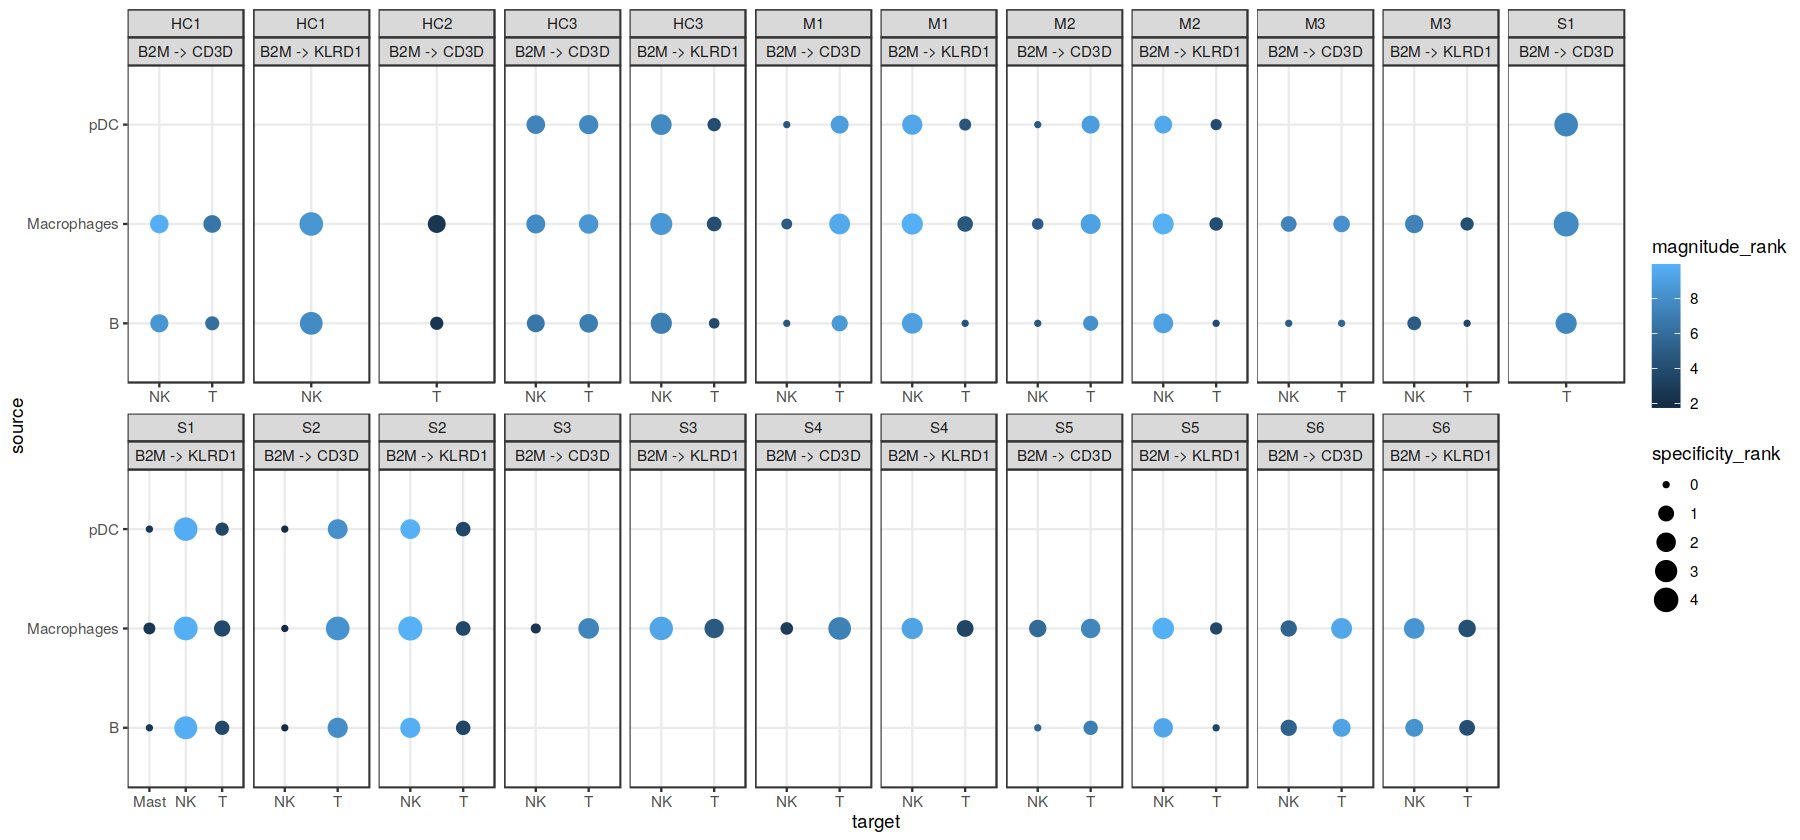

In [45]:
ligand_complex <- 'B2M'
receptor_complex <- c('CD3D', 'KLRD1')
source_labels <- c("B", "pDC", "Macrophages")
target_labels <- c("T", "Mast", "pDC", "NK")
sample_key <- 'sample_new'
colour <- 'magnitude_rank'
size <- "specificity_rank"

lv <- liana_res %>% 
    filter(source %in% source_labels) %>%
    filter(target %in% target_labels) %>%
    filter(ligand.complex %in% ligand_complex) %>%
    filter(receptor.complex %in% receptor_complex) %>%
    unite(lr.pairs, ligand.complex, receptor.complex, sep = ' -> ') %>%
    mutate(lr.pairs = factor(lr.pairs, levels = unique(lr.pairs))) %>%
    # inverse ranks
    mutate_at(vars(specificity_rank, magnitude_rank), ~-log10(. + 1e-10))

h_ = 7
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)

ggplot(lv, aes(x = target, y = source, color = .data[[colour]], size=.data[[size]])) +
        geom_point() + 
        facet_wrap(sample_new ~ lr.pairs, ncol = 12, scales='free_x') + 
        theme_bw()

Let's export it in case we want to access it later:

In [46]:
write.csv(liana_res, file.path(output_folder, '/rLIANA_by_sample.csv'))

Alternatively, one could just export the whole SingleCellExperiment object, together with the ligand-receptor results stored:

In [48]:
saveRDS(covid_data, file.path(output_folder, '/sce_processed.rds'))

## Comparing cell-cell communication across multiple samples

We can use Tensor-cell2cell to infer context-dependent CCC patterns from multiple samples simultaneously. To do so, we must first restructure the communication scores (LIANA's output) into a 4D-Communication Tensor. 

The tensor is built as follows: we create matrices with the communication scores for each of the ligand-receptor pairs within the same sample, then generate a 3D tensor for each sample, and finally concatenate them to form the 4D tensor:

![ccc-scores](https://github.com/earmingol/cell2cell/blob/master/docs/tutorials/ASD/figures/4d-tensor.png?raw=true)

First, we generate a list containing all samples from our AnnData object. For visualization purposes we sorted them according toby COVID-19 severity. Here, we can find the names of each of the samples in the `sample_new` column of the adata.obs information:

In [49]:
sorted_samples = sort(names(covid_data@metadata$liana_res))

Then we can directly pass the communication scores from LIANA to build the 3D tensors for each sample (panel c in last figure), and concatenate them, with the following function:

In [55]:
# build the tensor
context_df_dict <- liana:::preprocess_scores(context_df_dict = covid_data@metadata[['liana_res']], 
                                             outer_frac = 1/3, # Fraction of samples as threshold to include cells and LR pairs.
                                             invert = TRUE, # transform the scores
                                             invert_fun = function(x) 1-x, # Transformation function
                                             non_negative = TRUE, # fills negative values
                                             non_negative_fill = 0 # set negative values to 0
                             )


tensor <- liana_tensor_c2c(context_df_dict = context_df_dict,
                          sender_col = "source", # Column name of the sender cells
                          receiver_col = "target", # Column name of the receiver cells
                          ligand_col = "ligand.complex", # Column name of the ligands
                          receptor_col = "receptor.complex", # Column name of the receptors
                          score_col = 'magnitude_rank', # Column name of the communication scores to use
                          how='outer',  # What to include across all samples
                          context_order=sorted_samples, # Order to store the contexts in the tensor
                          conda_env = 'ccc_protocols', # used to pass an existing conda env with cell2cell
                          build_only = TRUE,# , # set this to FALSE to combine the downstream rank selection and decomposition steps all here 
                          device = device # Device to use when backend is pytorch.
                        )

The key parameters when building a tensor are:

- `context_df_dict` is the dataframe containing the results from LIANA, usually located in `covid_data@metadata[['liana_res']]`. We can pass directly the AnnData object to the parameter adata in this function. If the AnnData object is passed, we do not need to specify the liana_res parameter.

- `sender_col`, `receiver_col`, `ligand_col`, `receptor_col`, and `score_col` are the column names in the dataframe containing the samples, sender cells, receiver cells, ligands, receptors, and communication scores, respectively. Each row of the dataframe contains a unique combination of these elements.

- `invert` and `invert_fun` control the function we use to convert the communication score before using it to build the tensor. In this case, the 'magnitude_rank' score generated by LIANA considers low values as the most important ones, ranging from 0 to 1. In contrast, Tensor-cell2cell requires higher values to be the most important scores, so here we pass a function (`function(x) 1-x`) to adapt LIANA's magnitude-rank scores (subtracts the LIANA's score from 1).

- `how` controls which ligand-receptor pairs and cell types to include when building the tensor. This decision depends on whether the missing values across a number of samples for both ligand-receptor interactions and sender-receiver cell pairs are considered to be biologically-relevant. Options are:
    - `'inner'` is the more strict option since it only considers only cell types and LR pairs that are present in all contexts (intersection).
    - `'outer'` considers all cell types and LR pairs that are present across contexts (union).
    - `'outer_lrs'` considers only cell types that are present in all contexts (intersection), while all LR pairs that are present across contexts (union).
    - `'outer_cells'` considers only LR pairs that are present in all contexts (intersection), while all cell types that are present across contexts (union).

- `outer_frac` controls the elements to include in the union scenario of the `how` options. Only elements that are present at least in this fraction of samples/contexts will be included. When this value is 0, the tensor includes all elements across the samples. When this value is 1, it acts as using `how='inner'`.

- `context_order` is a list specifying the order of the samples. The order of samples does not affect the results, but it is useful for posterior visualizations.

We can check the shape of this tensor to verify the number of samples, LR pairs, sender cells, adn receiver cells, respectively:

In [56]:
tensor$shape

torch.Size([12, 1419, 10, 10])

We can export our tensor:

In [57]:
reticulate::py_save_object(object = tensor, 
                           filename = file.path(output_folder, 'BALF-Tensor-R.pkl'))

Then, we can load it with:

In [60]:
tensor <- reticulate::py_load_object(filename = file.path(output_folder, 'BALF-Tensor-R.pkl'))

## Perform Tensor Factorization

Now that we have built the tensor and its metadata, we can run Tensor Component Analysis via Tensor-cell2cell with one simple command that we implemented for our unified framework:

In [63]:
tensor <- liana::decompose_tensor(tensor = tensor, 
                                  rank = NULL, # Number of factors to perform the factorization. If NULL, it is automatically determined by an elbow analysis
                                  tf_optimization = 'robust', # To define how robust we want the analysis to be.
                                  seed = 0, # Random seed for reproducibility
                                  factors_only = FALSE, 
                                  )

**Key parameters are:**

- `rank`  is the number of factors or latent patterns we want to obtain from the analysis. You can either indicate a specific number or leave it as `None` to perform the decomposition with a suggested number from an elbow analysis.

- `tf_optimization` indicates whether running the analysis in the `'regular'` or the `'robust'` way. The `'regular'` way runs the tensor decomposition less number of times than the robust way to select an optimal result. Additionally, the former employs less strict convergence parameters to obtain optimal results than the latter, which is also translated into a faster generation of results.

- `seed` is the seed for randomization. It controls the randomization used when initializing the optimization algorithm that performs the tensor decomposition. It is useful for reproducing the same result every time that the analysis is run. If `NULL`, a different randomization will be used each time.

In [66]:
print(paste0('The estimated tensor rank is: ', tensor$rank))

[1] "The estimated tensor rank is: 11"


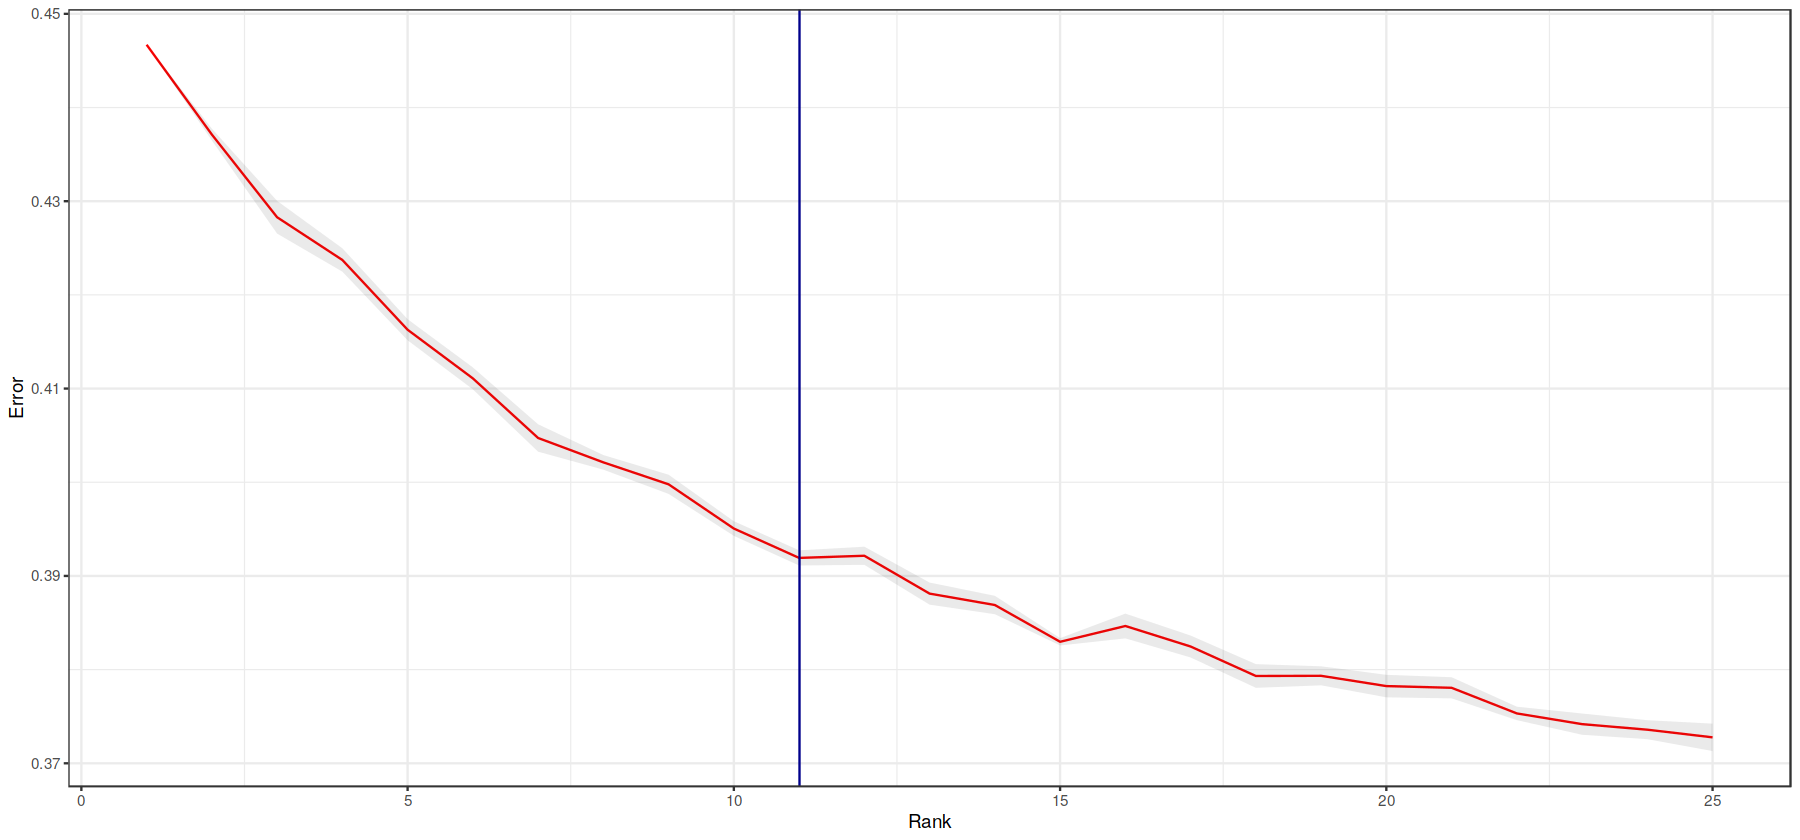

In [64]:
# Estimate standard error
error_average <- tensor$elbow_metric_raw %>%
    t() %>%
    as.data.frame() %>%
    mutate(rank=row_number()) %>% 
    pivot_longer(-rank, names_to = "run_no", values_to = "error") %>%
    group_by(rank) %>%
    summarize(average = mean(error),
              N = n(),
              SE.low = average - (sd(error)/sqrt(N)),
              SE.high = average + (sd(error)/sqrt(N))
           )

# plot
error_average %>%
    ggplot(aes(x=rank, y=average), group=1) +
    geom_line(col='red') + 
    geom_ribbon(aes(ymin = SE.low, ymax = SE.high), alpha = 0.1) +
    geom_vline(xintercept = tensor$rank, colour='darkblue') + # rank of interest
    theme_bw() +
    labs(y="Error", x="Rank")

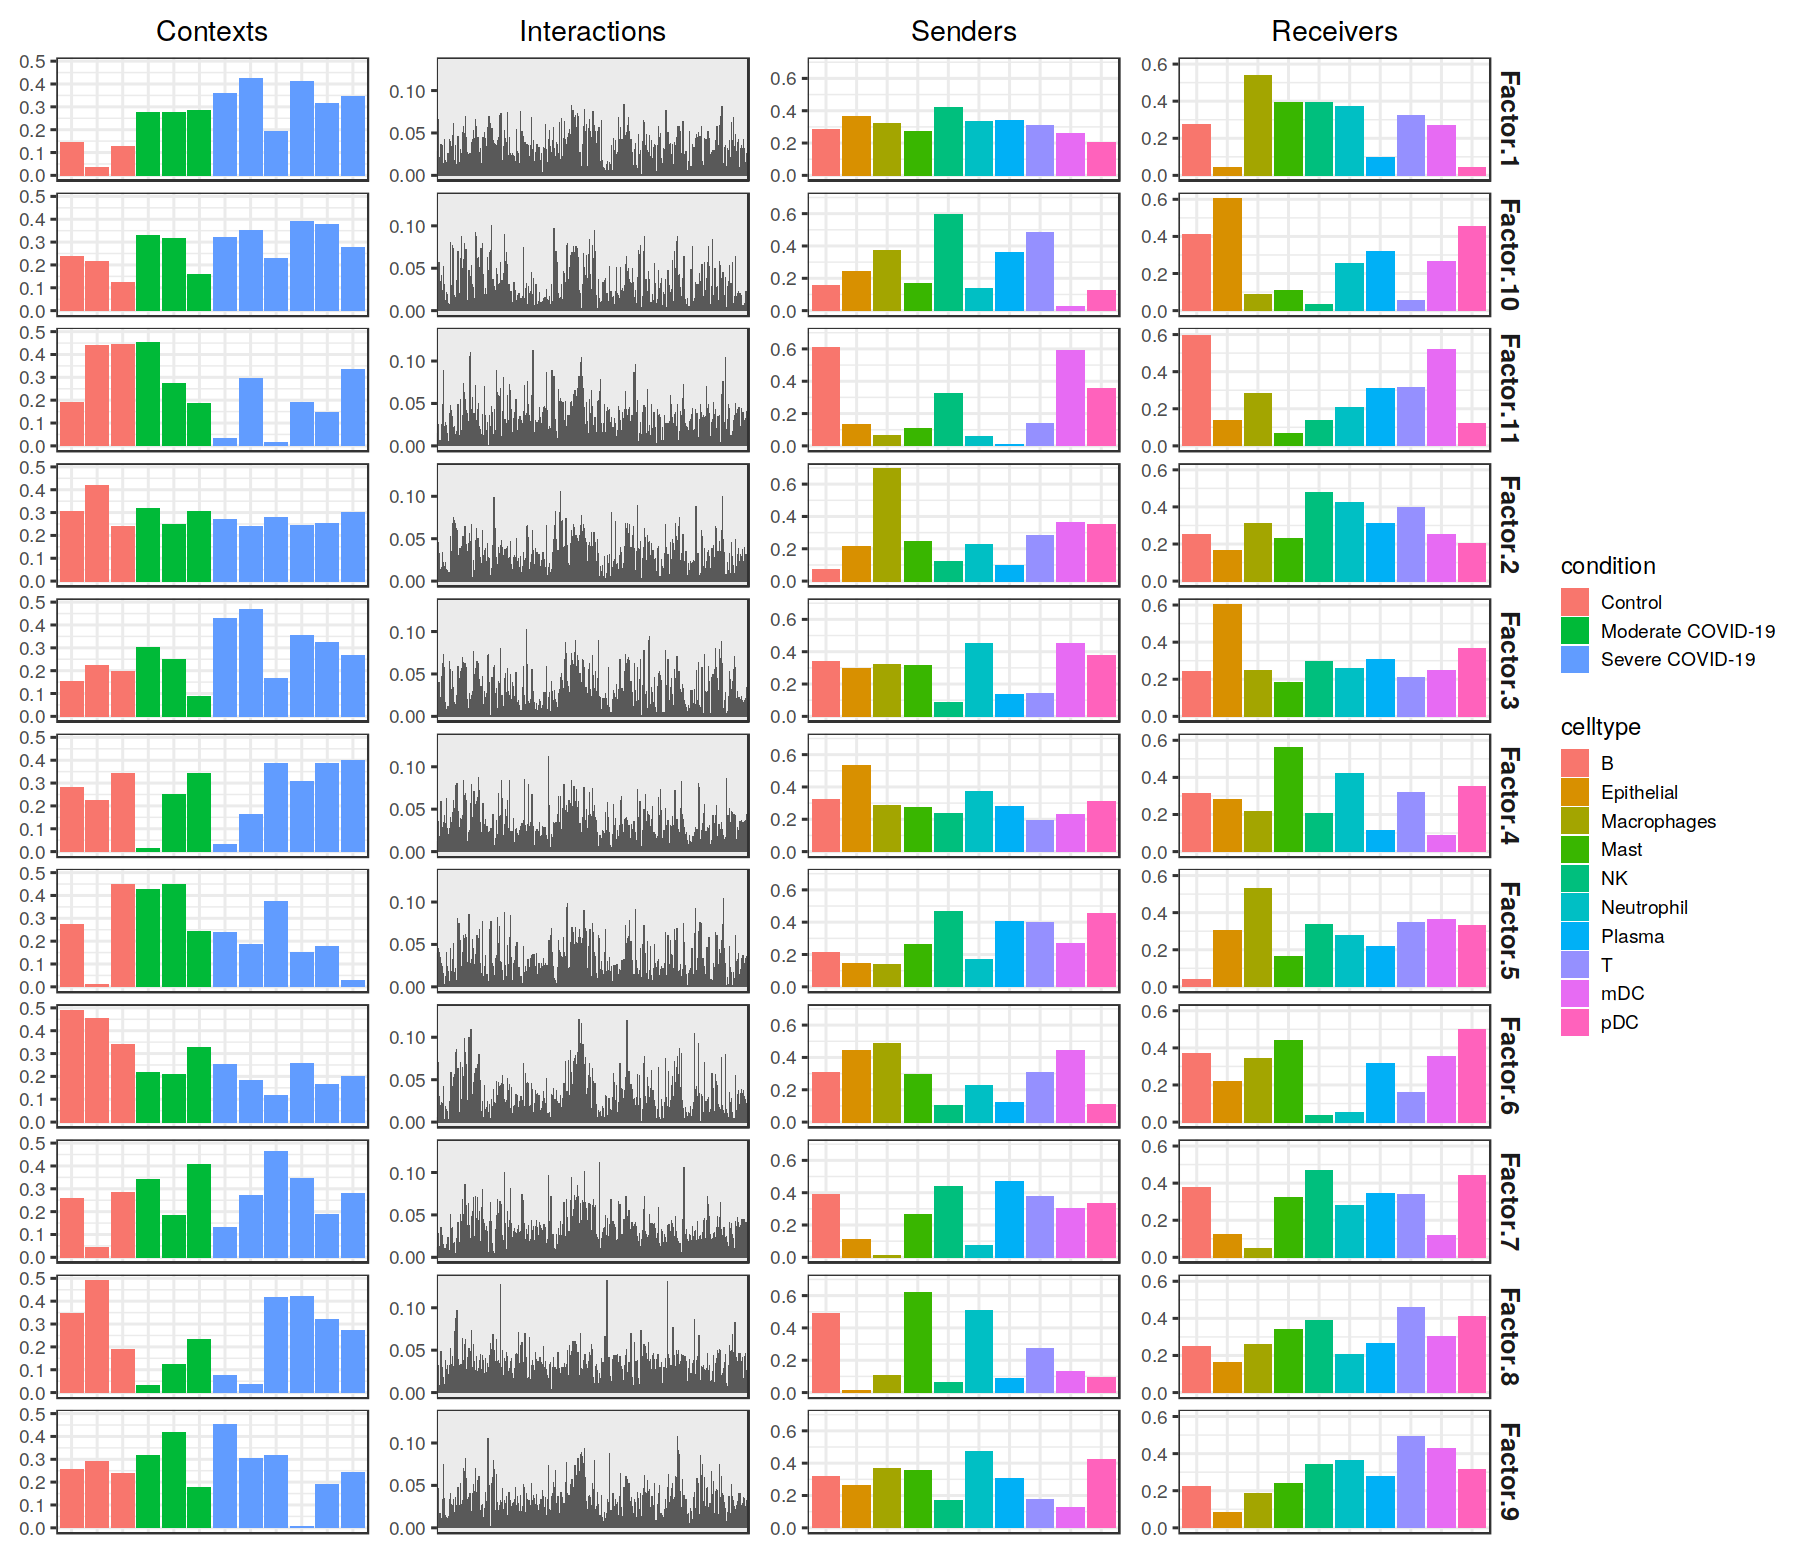

In [65]:
covid_data@metadata$tensor_res <- liana:::format_c2c_factors(tensor$factors)

h_ = 13
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)

plot_c2c_overview(sce = covid_data, group_col = 'condition', sample_col = 'sample_new')

The figure representing the loadings in each factor generated here can be interpreted by interconnecting all dimensions within a single factor. For example, if we take one of these factors, the cell-cell communication program occurs in each sample proportionally to their loadings. Then, this signature can be interpreted with the loadings of the ligand-receptor pairs, sender cells, and receiver cells. Ligands in high-loading ligand-receptor pairs are sent predominantly by high-loading sender cells, and interact with the cognate receptors on the high-loadings receiver cells.

### Downstream Visualizations: Making sense of the factors

After running the decomposition, the results are stored in the `factors` attribute of the tensor object. This attribute is a dictionary containing the loadings for each of the elements in every tensor dimension. Loadings delineate the importance of that particular element to that factor. Keys are the names of the different dimension.

In [67]:
names(tensor$factors)

[1] "contexts"     "interactions" "senders"      "receivers"

We can inspect the loadings of the samples, for example, located under the key `'Contexts'`:

In [69]:
tensor$factors[['contexts']]

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5,Factor 6,Factor 7,Factor 8,Factor 9,Factor 10,Factor 11
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HC1,0.14316522,0.3065290,0.15305687,0.28130668,0.27225703,0.4868134,0.25740293,0.34741580,0.253281802,0.2360851,0.19132936
HC2,0.03640297,0.4168379,0.22217795,0.22359507,0.01001501,0.4533435,0.04157614,0.49194807,0.288356811,0.2136957,0.43802860
HC3,0.12754396,0.2387836,0.19773847,0.34051272,0.44670001,0.3394062,0.28265968,0.18821898,0.239248484,0.1230038,0.44578603
M1,0.27365792,0.3196401,0.30153593,0.01166345,0.42538953,0.2192126,0.34233484,0.02880623,0.317588985,0.3298262,0.45320800
M2,0.27428582,0.2468491,0.24892616,0.25125945,0.44804662,0.2099967,0.18311027,0.12444694,0.415983289,0.3172991,0.27242061
M3,0.28524718,0.3049264,0.08678239,0.34178278,0.24179280,0.3272718,0.40592456,0.23346446,0.175394073,0.1592992,0.18343055
S1,0.35646284,0.2697758,0.42814210,0.03167536,0.23940764,0.2517207,0.12903492,0.07314033,0.452302873,0.3216996,0.03177959
S2,0.42457190,0.2389240,0.46748042,0.16409321,0.18320760,0.1803486,0.27205127,0.03710565,0.302229017,0.3502277,0.29675725
S3,0.18989520,0.2779660,0.16367847,0.38493976,0.37399378,0.1161264,0.46363232,0.41599455,0.316854000,0.2275728,0.01636855


## Downstream Visualizations

We can use these loadings to compare pairs of sample major groups with boxplots and statistical tests:

In [76]:
sample_loadings <- liana::get_c2c_factors(covid_data,
                                          sample_col='sample_new',
                                          group_col='condition') %>%
                                          purrr::pluck("contexts") %>% 
                                          pivot_longer(-c("condition", "context"),
                                                names_to = "factor",
                                                values_to = "loadings") %>% 
                                          mutate(factor = factor(factor)) %>%
                                          mutate(factor = fct_relevel(factor, "Factor.10", after=9))

h_ = 10
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)

# Do pairwise tests
pwc <- sample_loadings %>%
    group_by(factor) %>%
    rstatix::pairwise_t_test(
      loadings ~ condition, 
      p.adjust.method = "fdr"
      )

# plot
pwc <- pwc %>% add_xy_position(x = "condition")
ggboxplot(sample_loadings, x = "condition", y = "loadings", add = "point", fill="condition") +
    facet_wrap(~factor, ncol = 4) +
    stat_pvalue_manual(pwc) +
    theme_bw() + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

Using the loadings for any dimension, we can also generate heatmaps for the elements with loadings above a certain threshold. Additionally, we can cluster these elements by the similarity of their loadings across all factors:

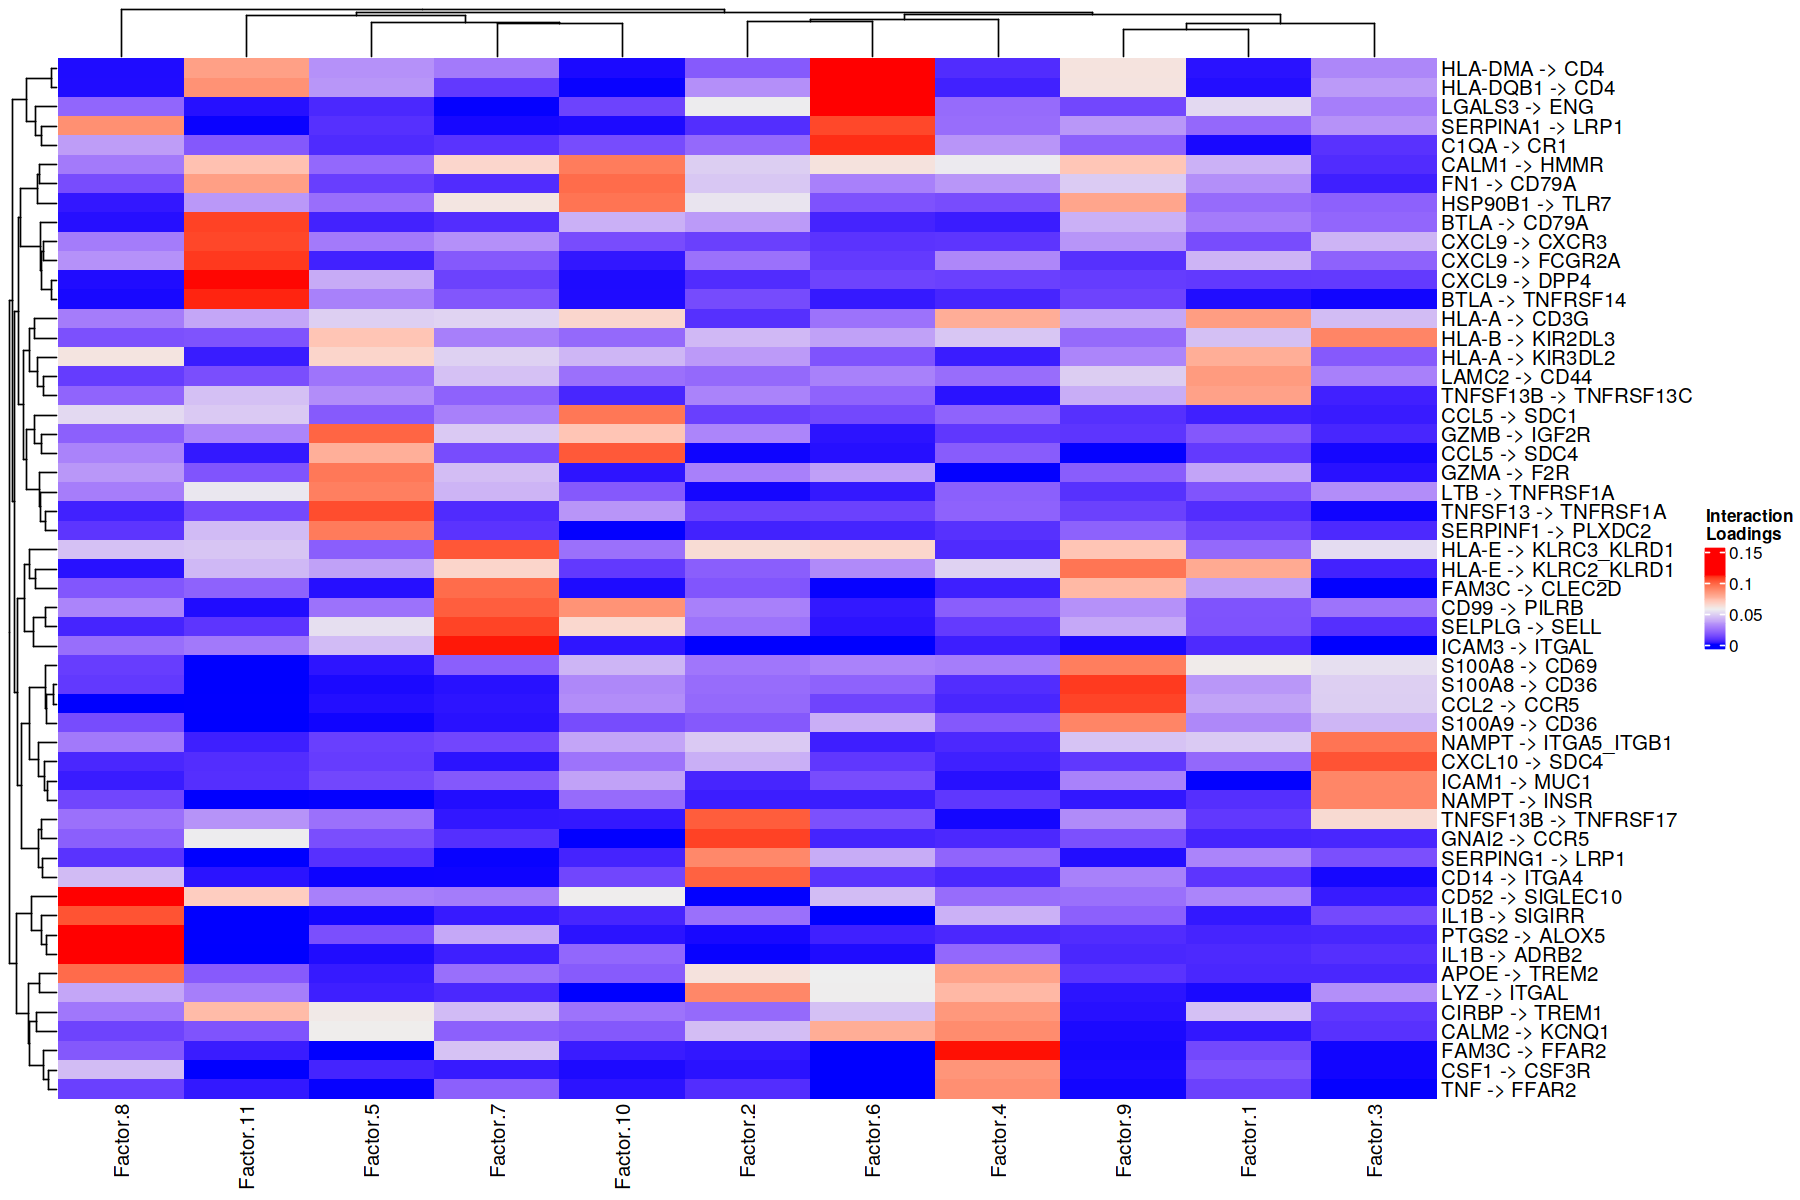

In [93]:
h_ = 10
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)

liana::plot_lr_heatmap(sce = covid_data,  n = 5)

Here patients are grouped by the importance that each communication pattern (factor) has in relation to the other patients. This captures combinations of related communication patterns that explain similarities and differences at a sample-specific resolution. In this case the differences are reflected with an almost perfect clustering by COVID-19 severity, where moderate cases are more similar to control cases.

## Pathway Enrichment Analysis: Interpreting the context-driven communication

### Classical Pathway Enrichment

As the number of inferred interactions increases, the interpretation of the inferred cell-cell communication networks becomes more challenging. To this end, we can perform pathway enrichment analysis to identify the general biological processes that are enriched in the inferred interactions. Here, we will perform classical gene set enrichment analysis with `KEGG Pathways`.

For the pathway enrichment analysis with GSEA, we use ligand-receptor pairs instead of individual genes. KEGG was initially designed to work with sets of genes, so first we need to generate ligand-receptor sets for each of it’s pathways:

In [97]:
# Generate list with ligand-receptors pairs in DB
lr_pairs <- liana::select_resource('Consensus')[[1]] %>%
    select(ligand = source_genesymbol, receptor = target_genesymbol)
lr_list <- lr_pairs %>%
     unite('interaction', ligand, receptor, sep = '^') %>% 
     pull(interaction)

# Specify the organism and pathway database to use for building the LR set
organism = "human"
pathwaydb = "KEGG"

# Generate ligand-receptor gene sets
lr_set <- c2c$external$generate_lr_geneset(lr_list = lr_list, 
                                           complex_sep='_', # Separation symbol of the genes in the protein complex
                                           lr_sep='^', # Separation symbol between a ligand and a receptor complex
                                           organism=organism,
                                           pathwaydb=pathwaydb,
                                           readable_name=TRUE
                                           )

Next, we can perform enrichment analysis on each factor using the loadings of the ligand-receptor pairs to obtain the normalized-enrichment scores (NES) and corresponding P-values from GSEA:

In [107]:
factors <- liana::get_c2c_factors(sce = covid_data,
                            sample_col = "sample_new",
                            group_col = "condition")

lr_loadings = factors[['interactions']] %>% 
                column_to_rownames("lr")

gsea_res <- c2c$external$run_gsea(loadings=lr_loadings, 
                               lr_set=lr_set,
                               output_folder=output_folder,
                               weight=as.integer(1),
                               min_size=as.integer(15),
                               permutations=as.integer(999),
                               processes=as.integer(6),
                               random_state=as.integer(6),
                               significance_threshold=as.numeric(0.05)
                              )
names(gsea_res)<-c('pvals', 'scores', 'gsea_df')

The enriched pathways for each factor are:

In [108]:
gsea_df <- gsea_res$gsea_df
gsea_df %>% 
    filter(`Adj. P-value` < 0.05 & NES > 0) %>%
    arrange(desc(abs(NES)))

,Factor,Term,NES,P-value,Adj. P-value
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
80,Factor.7,GRAFT VERSUS HOST DISEASE,1.781234,0.001000000,0.008897787
81,Factor.7,NATURAL KILLER CELL MEDIATED CYTOTOXICITY,1.749077,0.001000000,0.008897787
82,Factor.7,ANTIGEN PROCESSING AND PRESENTATION,1.685809,0.001000000,0.008897787
48,Factor.5,ANTIGEN PROCESSING AND PRESENTATION,1.652595,0.001000000,0.008897787
32,Factor.4,ANTIGEN PROCESSING AND PRESENTATION,1.641395,0.001000000,0.008897787
49,Factor.5,GRAFT VERSUS HOST DISEASE,1.627548,0.001000000,0.008897787
112,Factor.9,ANTIGEN PROCESSING AND PRESENTATION,1.619193,0.001000000,0.008897787
64,Factor.6,ANTIGEN PROCESSING AND PRESENTATION,1.558965,0.001000000,0.008897787
1,Factor.2,ANTIGEN PROCESSING AND PRESENTATION,1.465722,0.001000000,0.008897787


The depleted pathways are:

In [109]:
gsea_df %>% 
    filter(`Adj. P-value` < 0.05 & NES < 0) %>%
    arrange(desc(abs(NES)))

,Factor,Term,NES,P-value,Adj. P-value
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
128,Factor.10,NOTCH SIGNALING PATHWAY,-1.759076,0.001,0.008897787
0,Factor.2,NOTCH SIGNALING PATHWAY,-1.504717,0.001,0.008897787


Finally, we can visualize the enrichment results using a dotplot:

In [114]:
gsea.dotplot<-function(pval_df, score_df, significance = 0.05, font_size = 15){
    pval_df <- pval_df[apply(pval_df<significance,1,any), apply(pval_df<significance, 2, any)] %>% 
            mutate_all(function(x) -1*log10(x + 1e-9))
    score_df <- score_df[rownames(pval_df), colnames(pval_df)]
    pval_df <- pval_df %>%
                    tibble::rownames_to_column('Annotation')
    score_df <- score_df %>%
                    tibble::rownames_to_column('Annotation')

    viz_df <- cbind(melt(pval_df), melt(score_df)[[3]])
    names(viz_df) <- c('Annotation', 'Factor', 'Significance', 'NES')
    
                       
    dotplot <- ggplot(viz_df, aes(x = Factor, y = Annotation)) + geom_point(aes(size = Significance, color = NES)) + 
                scale_color_gradient2() + theme_bw(base_size = font_size) + 
                theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=0.5))+
                       scale_size(range = c(0, 8)) + 
                       guides(size=guide_legend(title="-log10(p-value)"))
    return(dotplot)
}


Using Annotation as id variables

Using Annotation as id variables



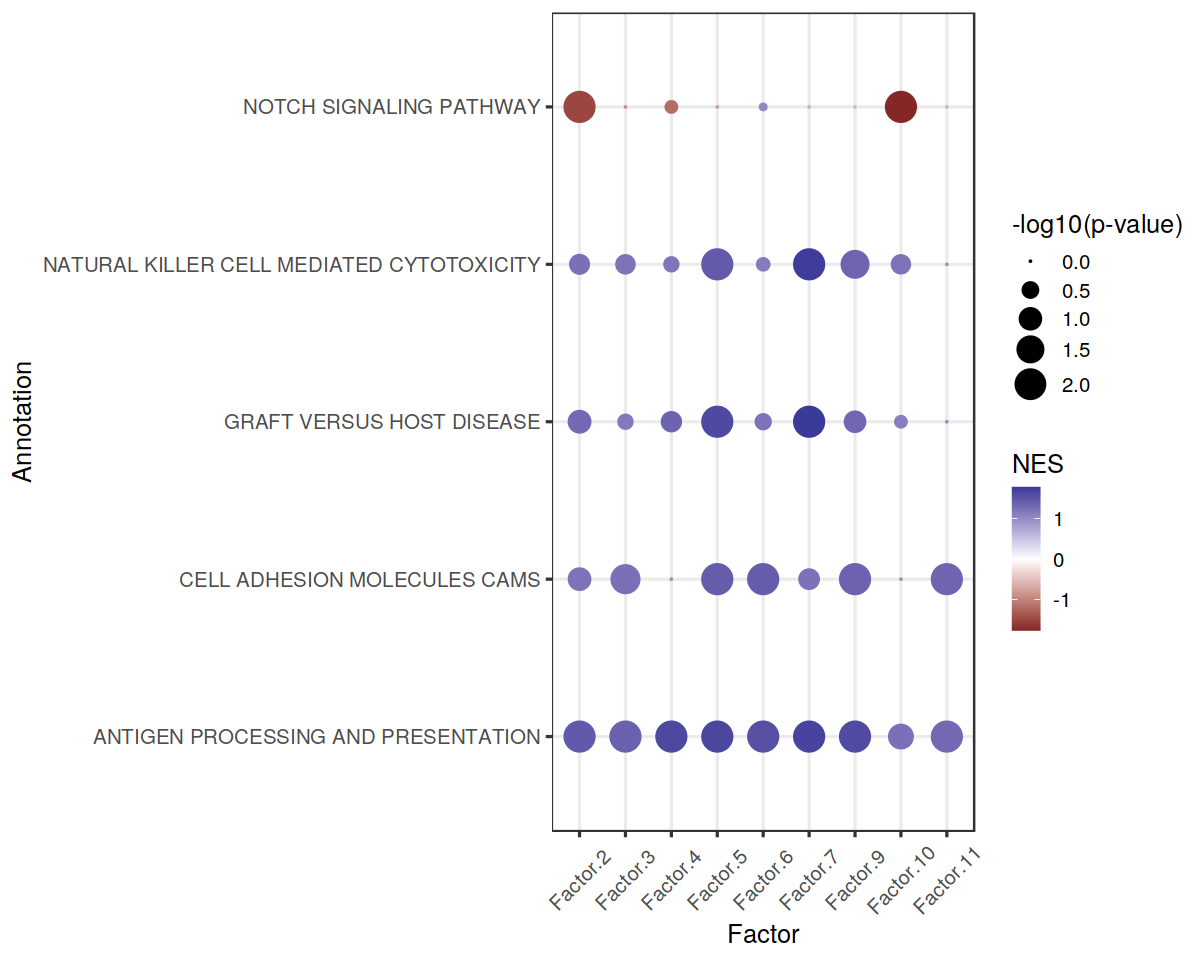

In [115]:
h_ = 8
w_ = 10
options(repr.plot.height=h_, repr.plot.width=w_)

dotplot <- gsea.dotplot(pval_df = gsea_res$pvals, 
                       score_df = gsea_res$scores, 
                       significance = 0.05)
dotplot

### Footprint Enrichment

Footprint enrichment analysis build upon classic geneset enrichment analysis, as instead of considering the genes involved in a biological activity, they consider the genes affected by the activity, or in other words the genes that change downstream of said activity [(Dugourd and Saez-Rodriguez, 2019)](https://www.sciencedirect.com/science/article/pii/S2452310019300149). 

In this case, we will use the PROGENy pathway resource to perform footprint enrichment analysis. PROGENy was built in a data-driven manner using perturbation and cancer lineage data [(Schubert et al, 2019)](https://www.nature.com/articles/s41467-017-02391-6#Sec8), as a consequence it also assigns different importances or weights to each gene in its pathway genesets. To this end, we need an enrichment method that can take weights into account, and here we will use multi-variate linear models from the `decoupler-py` package to perform this analysis [(Badia-i-Mompel et al., 2022)](https://academic.oup.com/bioinformaticsadvances/article/2/1/vbac016/6544613).

Let’s load the PROGENy genesets and then convert them to sets of weighted ligand-receptor pairs:

In [124]:
# obtain progeny gene sets
net <- decoupleR::get_progeny(organism = 'human', top=5000) %>%
    dplyr::select(-p_value)

# convert to LR sets
progeny_lr <- liana::generate_lr_geneset(sce = covid_data,
                                          resource = net)

Next, we can run the footprint enrichment analysis:

In [125]:
# interaction loadings to matrix
mat <- factors$interactions %>%
    textshape::column_to_rownames("lr") %>%
  as.matrix()

# run enrichment analysis with decoupler
# (we fit a univariate linear model for each gene set)
# We don't consider genesets with minsize < 10
res <- decoupleR::run_ulm(mat = mat,
                          network = progeny_lr,
                          .source = "set",
                          .target = "lr",
                          minsize=10) %>%
  mutate(p_adj = p.adjust(p_value, method = "fdr"))

Finally, we can visualize the results:

In [126]:
res %>% # sig/isnig flag
  mutate(significant = if_else(p_adj <= 0.05, "signif.", "not")) %>%
  ggplot(aes(x=source, y=condition, shape=significant,
             colour=score, size=-log10(p_value+1e-36))) +
  geom_point() +
  scale_colour_gradient2(high = "red", low="blue") +
  scale_size_continuous(range = c(3, 12)) +
  scale_shape_manual(values=c(21, 16)) +
  theme_bw(base_size = 15) +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
  labs(x="Pathway",
       y="Factor",
       colour="Activity"
       )

Let's zoom in on **Factor <font color='red'>XXX</font>**, which is associated with COVID-19 cases. 

In [127]:
selected_factor = 'Factor.8'
sample_loadings <- liana::get_c2c_factors(covid_data,
                                          sample_col='sample_new',
                                          group_col='condition') %>%
                                          purrr::pluck("contexts") %>% 
                                          pivot_longer(-c("condition", "context"),
                                                names_to = "factor",
                                                values_to = "loadings") %>% 
                                          mutate(factor = factor(factor)) %>%
                                          mutate(factor = fct_relevel(factor, "Factor.10", after=9))

res.factor <- res %>% 
                filter(condition == selected_factor) %>%
                mutate(p_adj = p.adjust(p_value, method = "fdr")) %>%
                arrange(desc(score)) %>%
                mutate(source = factor(source, levels = source))